In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [4]:
# Cell 1: imports & setup
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageTabDataset
from src.models import EarlyFusionNet
from src.train import train_one_epoch_fusion, validate_fusion


main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp4")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp4"]   # define in config
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Cell 2: KFold CV (EffNet + tabular)
backbone_name = cfg["backbone"]           # "tf_efficientnet_b0_ns"
# backbone_name = "efficientnet_b0"
img_size = cfg["img_size"]                # 256
aug_type = cfg["aug"]                     # "lite"
loss_name = cfg["loss"]                   # "mse" 
head_type = cfg["head_type"]              # "mlp" 

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]
lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []

start_all = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    
    print(f"\n=== {cfg['name']}: Fold {fold+1} ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageTabDataset(train_df, img_folder, tab_cols, train_tf)
    val_ds = ImageTabDataset(val_df, img_folder, tab_cols, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=16)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=16)

    model = EarlyFusionNet(
        backbone_name=backbone_name,
        img_size=img_size,
        tab_input_dim=len(tab_cols),
        head_type=head_type,
        pretrained=True,
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    if loss_name == "bce":
        criterion = torch.nn.BCEWithLogitsLoss()
        scale_target = True
    else:
        criterion = torch.nn.MSELoss()
        scale_target = False

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )
    scaler = torch.amp.GradScaler("cuda")
    best_rmse = 1e10
    best_state = None
    epochs_no_improve = 0
    train_losses, val_rmses = [], []

    epoch_logs = []
    for epoch in range(epochs):
        avg_train_loss = train_one_epoch_fusion(
            model, train_loader, optimizer, criterion, device,scaler, scale_target
        )
        scheduler.step()
        rmse, val_preds, val_targets = validate_fusion(
            model, val_loader, device, scale_target
        )
       

        train_losses.append(avg_train_loss)
        val_rmses.append(rmse)

        print(f"Epoch {epoch+1}/{epochs} | Fold {fold+1} "
              f"TrainLoss: {avg_train_loss:.4f} ValRMSE: {rmse:.4f} "
            )
        epoch_logs.append({
            "fold": fold + 1,
            "epoch": epoch + 1,
            "train_loss": float(avg_train_loss),
            "val_rmse": float(rmse),
        })

        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    pd.DataFrame(epoch_logs).to_csv(
        os.path.join(out_dir, f"epoch_logs_fold{fold+1}.csv"), index=False
    )
    hist_df = pd.DataFrame({
        "epoch": range(1, len(train_losses)+1),
        "train_loss": train_losses,
        "train_rmse": np.sqrt(train_losses) if loss_name=="mse" else np.nan,
        "val_rmse": val_rmses,
    })
    hist_df.to_csv(os.path.join(out_dir, f"history_fold{fold+1}.csv"),
                   index=False)

    model.load_state_dict(best_state)
    _, val_preds, _ = validate_fusion(
        model, val_loader, device, scale_target
    )
    oof_pred[val_idx] = val_preds
    fold_rmse.append(best_rmse)
    print(f"Fold {fold+1} best RMSE: {best_rmse:.4f}")

    torch.save(best_state,
               os.path.join(out_dir, f"model_fold{fold+1}.pt"))

     # Clear memory
    del model, optimizer, train_loader, val_loader, train_ds, val_ds
    torch.cuda.empty_cache()
    gc.collect()

all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")

oof_rmse = root_mean_squared_error(df[TARGET], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df[TARGET],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)
np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp4_EffB1_TabMLP_Early_MLPHead: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 1555.1325 ValRMSE: 33.9739 
Epoch 2/10 | Fold 1 TrainLoss: 791.1964 ValRMSE: 24.9257 
Epoch 3/10 | Fold 1 TrainLoss: 378.6047 ValRMSE: 20.4286 
Epoch 4/10 | Fold 1 TrainLoss: 208.3062 ValRMSE: 20.1491 
Epoch 5/10 | Fold 1 TrainLoss: 137.2598 ValRMSE: 20.4998 
Epoch 6/10 | Fold 1 TrainLoss: 99.8408 ValRMSE: 20.5958 
Epoch 7/10 | Fold 1 TrainLoss: 77.9038 ValRMSE: 20.7030 
Epoch 8/10 | Fold 1 TrainLoss: 68.0644 ValRMSE: 20.6771 
Epoch 9/10 | Fold 1 TrainLoss: 62.2178 ValRMSE: 20.6008 
Early stopping at epoch 9
Fold 1 best RMSE: 20.1491

=== Exp4_EffB1_TabMLP_Early_MLPHead: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 1559.5163 ValRMSE: 32.4299 
Epoch 2/10 | Fold 2 TrainLoss: 779.8187 ValRMSE: 25.2995 
Epoch 3/10 | Fold 2 TrainLoss: 349.6454 ValRMSE: 20.0403 
Epoch 4/10 | Fold 2 TrainLoss: 195.6065 ValRMSE: 20.0050 
Epoch 5/10 | Fold 2 TrainLoss: 130.6803 ValRMSE: 20.6037 
Epoch 6/10 | Fold 2 TrainLoss: 97.5486 V

Grad-Cam

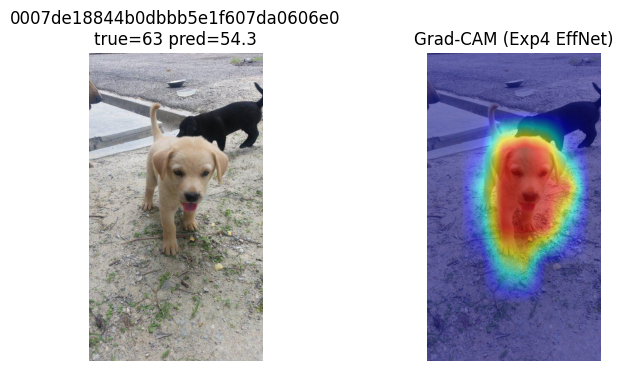

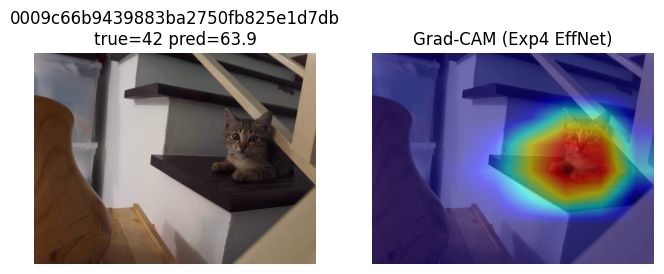

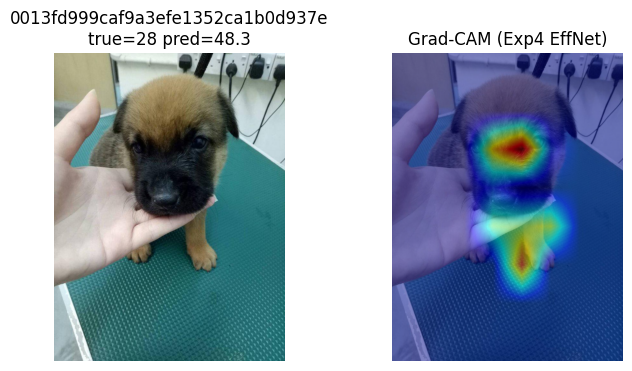

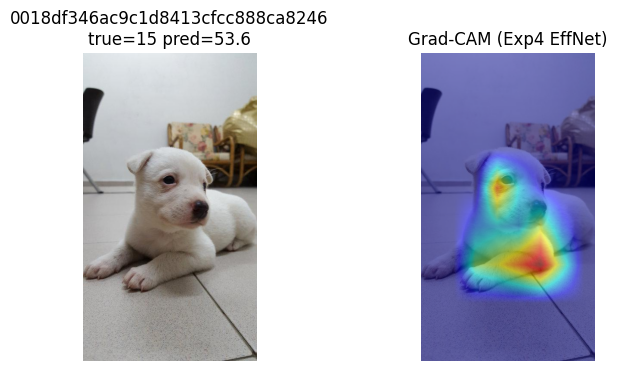

In [8]:
from src.models import EarlyFusionNet
from src.explain import get_last_conv_layer, compute_cnn_gradcam
from PIL import Image
backbone_name = cfg["backbone"]           # "tf_efficientnet_b0_ns"
# backbone_name = "efficientnet_b0"
img_size = cfg["img_size"]                # 256
aug_type = cfg["aug"]                     # "lite"
loss_name = cfg["loss"]                   # "mse" 
head_type = cfg["head_type"]              # "mlp" 

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]
lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

fold_to_vis = 1
model_path = os.path.join(out_dir, f"model_fold{fold_to_vis}.pt")

fusion_model = EarlyFusionNet(
    backbone_name=backbone_name,   # EfficientNet backbone from cfg
    img_size=img_size,
    tab_input_dim=len(tab_cols),
    head_type=head_type,
    pretrained=False,
)
fusion_model.load_state_dict(torch.load(model_path, map_location="cpu"))

eff_backbone = fusion_model.img_model
target_layer = get_last_conv_layer(eff_backbone)

err_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))

for _, row in err_df.head(4).iterrows():
    img_id = row.Id
    pil_img = Image.open(os.path.join(img_folder, f"{img_id}.jpg")).convert("RGB")
    overlay = compute_cnn_gradcam(
        eff_backbone,
        pil_img,
        img_size,
        target_layer=target_layer,
        device="cuda",
    )

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.axis("off")
    plt.title(f"{img_id}\ntrue={row.ytrue} pred={row.oof_pred:.1f}")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
    plt.title("Grad-CAM (Exp4 EffNet)")
    plt.show()
